In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData


# Heterogeneous Network

In [15]:
from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.network.omics_distance import compute_expression_correlations, compute_annotation_similarity


In [4]:
# READ Edgeslist
# network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                              directed=False)
# network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                              directed=True)
# network.remove_extra_nodes()

In [3]:
# WRITE Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                   data=True)

# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                   data=True)

In [4]:
import pickle

# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'wb') as file:
#     pickle.dump(network, file)

with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'rb') as file:
    network = pickle.load(file)
    network.remove_extra_nodes()

#  Split graph to train test and write to file

In [5]:
from moge.evaluation.utils import mask_test_edges
adj_train, train_edges, \
val_edges, test_edges = mask_test_edges(network.get_regulatory_edges_adjacency(), 
                                                 is_directed=True,
                                                 test_frac=.1, val_frac=.05,
                                                 prevent_disconnect=True, verbose=True)

preprocessing...
creating true edges...
edges in MST: 18383
Num WCC:  3790
Largest WCC num nodes:  18365
Largest WCC num edges:  301577
Fraction of train edges with both endpoints in L-WCC:  1.0
Fraction of test edges with both endpoints in L-WCC:  1.0
Fraction of val edges with both endpoints in L-WCC:  1.0
final checks for disjointness...
creating adj_train...
Done with train-test split!
Num train edges (true, ): ( 301577 , 
Num test edges (true, ): ( 35479 , 
Num val edges (true, ): ( 17739 , 


In [30]:
np.sum(adj_train[val_edges[:,0], val_edges[:,1]])

16385.92

In [31]:
val_edges.shape

(17739, 2)

# Add Correlation edges

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

## Network Info & Visualizations

In [23]:
print("isolated nodes:", len(nx.isolates(network.get_subgraph(modalities=["MIR", "GE"]))),
      ", out of total nodes:", network.all_nodes.__len__())
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

isolated nodes: 1988 , out of total nodes: 22342
edges:  12171466


In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

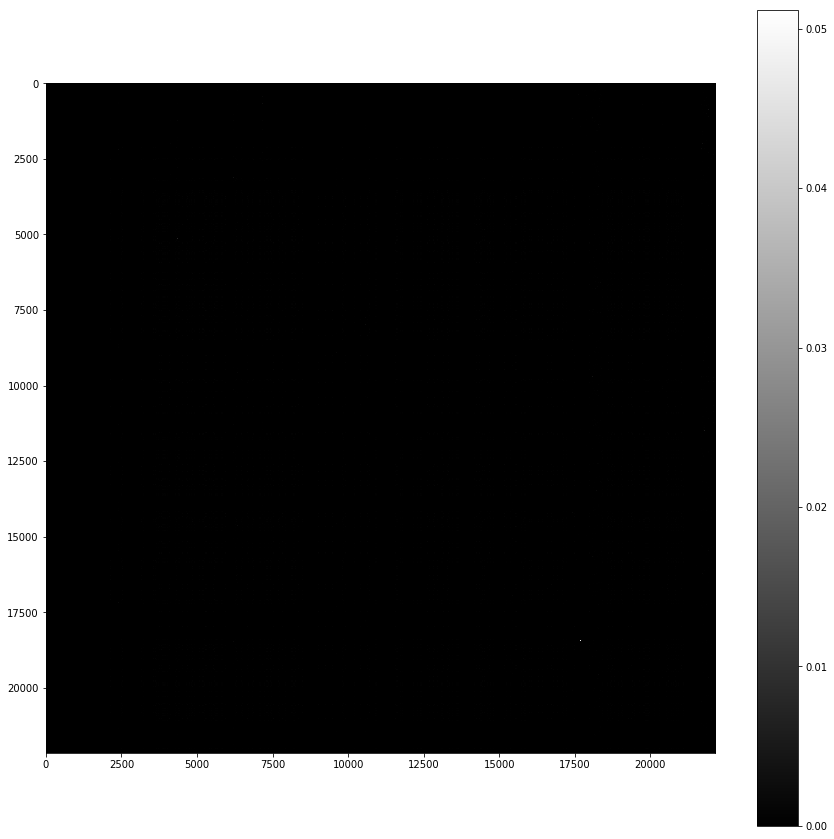

In [40]:
# Scatter plot of original graph adjacency matrix
plt.figure(figsize=(15, 15))
plt.imshow(graph_emb.get_reconstructed_adj(edge_type="u"), interpolation='none', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [37]:
import matplotlib.pyplot as plt

def plot(X, figsize=(10,10), cmap=plt.cm.gray):
    plt.figure(figsize=figsize)
    plt.imshow(X, interpolation='none', cmap=cmap)
    plt.colorbar()
    plt.show()

# Training Source Target Graph Embedding

In [92]:
import tensorflow as tf
tf.reset_default_graph()
sess.close()
sess = tf.InteractiveSession()

In [93]:
with tf.name_scope('inputs'):
    E_i_ = tf.sparse_placeholder(tf.float32, name="E_i_")
    is_directed = tf.placeholder(tf.bool, name="is_directed")
    i = tf.Variable(int, name="i", trainable=False)


emb_s = tf.Variable(initial_value=tf.random_uniform([len(network.all_nodes), 64], -1, 1),
                         validate_shape=True, dtype=tf.float32,
                         name="emb_s", trainable=True)

emb_t = tf.Variable(initial_value=tf.random_uniform([len(network.all_nodes), 64], -1, 1),
                         validate_shape=True, dtype=tf.float32,
                         name="emb_s", trainable=True)

emb_c = tf.concat([emb_s, emb_t], axis=1, name="emb_concat")

# 1st order (directed proximity)
p_1 = tf.sigmoid(tf.matmul(tf.slice(emb_s, [i, 0], [1, emb_s.get_shape()[1]]),
                           emb_t,
                           transpose_b=True, name="p_1_inner_prod"), name="p_1")
# print("E_i_:", E_i_)
# print("p_1:", p_1)
# print("tf.sparse_tensor_dense_matmul(E_i_, tf.log(p_1)):", tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1)), ))

loss_f1 = tf.reduce_sum(-tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1))), name="loss_f1")

# 2nd order proximity
p_2_exps = tf.matmul(tf.slice(emb_c, [i, 0], [1, emb_c.get_shape()[1]], name="p_2_exps_i"),
                    emb_c,
                    transpose_b=True) # dim (1, n_nodes)
p_2 = tf.nn.softmax(p_2_exps - tf.reduce_max(p_2_exps, axis=1),
                             axis=1, name="p_2_softmax")
# print("p_2:", p_2)
# print("tf.sparse_tensor_dense_matmul(E_i_, tf.log(p_2)):", tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_2))))
loss_f2 = tf.reduce_sum(-tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_2))), name="loss_f2")

loss = tf.cond(is_directed, true_fn=lambda: loss_f1, false_fn=lambda: loss_f2)

# Add the loss value as a scalar to summary.
tf.summary.scalar('loss', loss)
# tf.summary.scalar("E_i_.dense_shape", E_i_.dense_shape)
merged = tf.summary.merge_all()

# Initialize variables
init_op = tf.global_variables_initializer()

# SGD Optimizer
optimizer = tf.train.GradientDescentOptimizer(0.1)\
    .minimize(loss, var_list=[emb_s, emb_t])

sess.run(init_op)

In [83]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return indices, coo.data, coo.shape


In [17]:
adj = network.get_regulatory_edges_adjacency()

In [58]:
Ed_rows, Ed_cols = adj.nonzero()
Ed_random_idx = list(np.unique(Ed_rows))

In [94]:
idx=3
Ed_i_sparse = convert_sparse_matrix_to_sparse_tensor(adj[idx, :])
feed_dict = {E_i_: Ed_i_sparse, is_directed: True, i: idx}
feed_dict

{<tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fcdc32aa828>: (matrix([[    0,  1871],
          [    0,  1886],
          [    0,  1894],
          ...,
          [    0, 22136],
          [    0, 22141],
          [    0, 22151]], dtype=int32),
  array([0.49, 0.59, 1.  , ..., 0.57, 1.  , 1.  ]),
  (1, 22154)),
 <tf.Tensor 'inputs/is_directed:0' shape=<unknown> dtype=bool>: True,
 <tf.Variable 'inputs/i:0' shape=() dtype=int32_ref>: 3}

In [95]:
sparse_matmul_1 = tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1)))

In [96]:
_, summary, loss_val, a1, a2, a3 = sess.run([optimizer, merged, loss, p_1, p_2, sparse_matmul_1], feed_dict=feed_dict)
print(loss_val, a1.shape, a2.shape, a3.shape)

1493.6848 (1, 22154) (1, 22154) (1, 1)


# Training SourceTargetGraphEmbedding

In [10]:
from moge.embedding.dual_graph_embedding import SourceTargetGraphEmbedding

graph_emb = SourceTargetGraphEmbedding(d=64, lr=0.0001, Ed_Eu_ratio=None, epochs=50, batch_size=5000)
# graph_emb.learn_embedding(network, seed=0)


In [11]:
graph_emb.import_embedding("/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_source_target_embeddings_128.embeddings",
                          node_list=network.all_nodes)

# graph_emb.save_embeddings("miRNA-mRNA_source_target_embeddings_128.embeddings")

In [12]:
print(network.get_adjacency_matrix()[network.all_nodes.index('hsa-let-7b'), network.all_nodes.index('hsa-let-7c')])
graph_emb.get_edge_weight(network.all_nodes.index('hsa-let-7b'), network.all_nodes.index('hsa-let-7c'), edge_type="u")

0.9772727272727273


2.460062750089741e-08

In [110]:
adj = graph_emb.get_reconstructed_adj(edge_type='d')

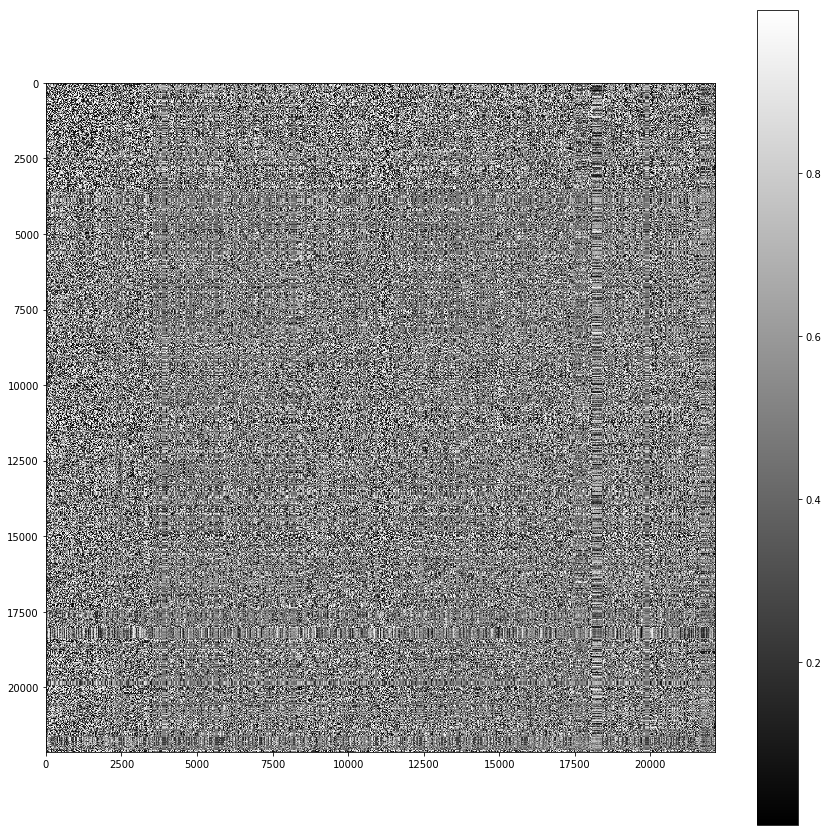

In [112]:
plot(graph_emb.get_reconstructed_adj(edge_type='d'), figsize=(15,15))

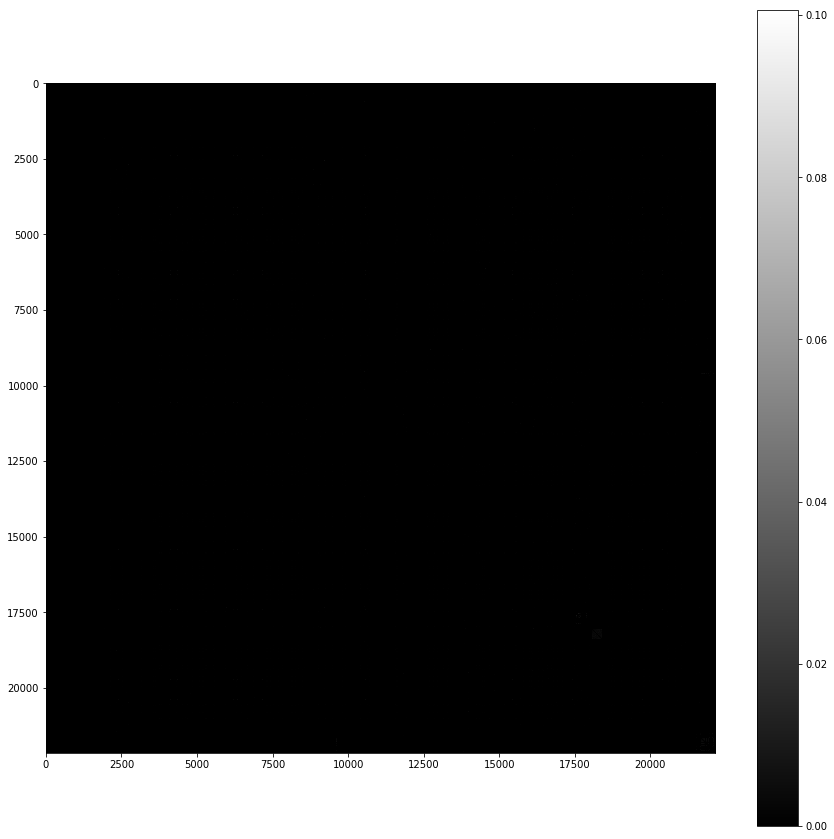

In [113]:
plot(graph_emb.get_reconstructed_adj(edge_type='u'), figsize=(15,15))

# Import different models

In [112]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/miRNA-mRNA_LINE.txt", 
                          node_list=network.all_nodes)

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt", 
                          node_list=network.all_nodes)

node_list = list(set(line_emb.node_list) & set(node2vec_emb.node_list))

In [114]:
models = []
models.append(graph_emb)
# models.append(line_emb)
# models.append(node2vec_emb)

# Evaluate Graph Reconstruction

In [5]:
from moge.evaluation.graph_reconstruction import evaluateStaticGraphReconstruction
# Directed edges
for model in models:
    print("\n",model.get_method_name())
    norm, avg = evaluateStaticGraphReconstruction(network, model, edge_type="d", sample_ratio=1.0, 
                                             node_list=node_list)
    print(norm, avg)

NameError: name 'models' is not defined

In [105]:
# Undirected edges
for model in models:
    print("\n",model.get_method_name())
    scores = evaluateStaticGraphReconstruction(network, model, edge_type="u", sample_ratio=1.0, 
                                             node_list=node_list)
    print(scores)


 source_target_graph_embedding
Sampling 355150 edges to be evaluated.
312.87635394572385 0.41637715777956286

 LINE
Sampling 355150 edges to be evaluated.
218.32465358288118 0.13672804522245333

 node2vec
Sampling 355150 edges to be evaluated.


IndexError: index 18765 is out of bounds for axis 0 with size 18755

In [ ]:
adj = network.get_adjacency_matrix(edge_type=["u"])
sim = network.get_node_similarity_adjacency()


In [51]:
np.sum(np.square(np.diag((adj-sim).todense())))

355.0

In [ ]:
np.linalg.norm((adj-sim).todense(), "fro")

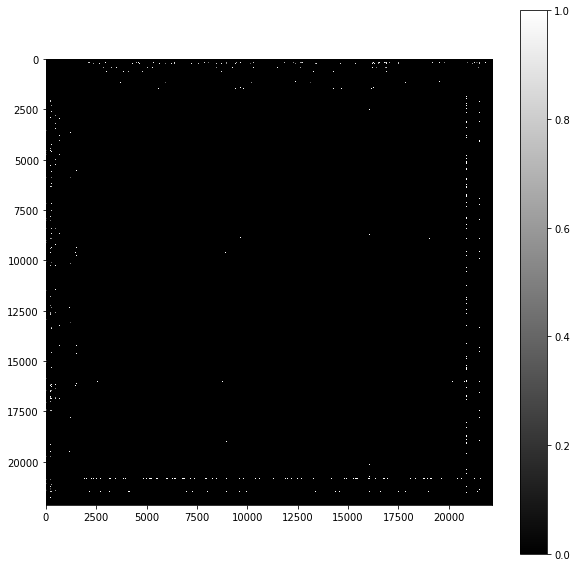

In [53]:
plot((adj).todense())

# Evaluate Link Prediction

In [14]:
from moge.evaluation.link_prediction import evaluate_top_k_link_prediction
from moge.embedding.dual_graph_embedding import SourceTargetGraphEmbedding

# Directed edges
evaluate_top_k_link_prediction(top_k=10000, network=network, 
                             graph_emb=graph_emb, train_embedding=False,
                             edge_type="d", test_frac=0.001, seed=0)

test_edges: 354
top k predicted edges: [1. 1. 1. ... 1. 1. 1.]


{'precision': 0.0001, 'recall': 0.002824858757062147}

In [13]:
# Undirected edges
evaluate_top_k_link_prediction(top_k=100000, network=network, 
                             graph_emb=graph_emb, train_embedding=False,
                             edge_type="u", test_frac=0.001, seed=0)

test_edges: 11755
top k predicted edges: [0.204 0.152 0.15  ... 0.001 0.001 0.001]


{'precision': 0.010771615742361355, 'recall': 0.09167517875383044}

# Import GEM Graph Embedding Methods

In [54]:
models = []
# You can comment out the methods you don't want to run
# models.append(HOPE(d=100, beta=0.1))
# models.append(GraphFactorization(d=200, max_iter=100, eta=1*10**-4, regu=1.0))
models.append(LaplacianEigenmaps(d=200))
models.append(LocallyLinearEmbedding(d=200))
# models.append(node2vec(d=200, max_iter=10, walk_len=80, num_walks=10, con_size=10, ret_p=1, inout_p=1))
# models.append(SDNE(d=200, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, 
#                    K=3, n_units=[50, 15,], rho=0.3, 
#                    n_iter=100, xeta=0.01, n_batch=500))

# models.append(DualGraphEmbedding(d=100, reg=1.0, lr=0.05, iterations=100))
                   

In [55]:
print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
for embedding in models:
    try:
        print("\n", embedding.get_method_name(), embedding.get_method_summary())
        t1 = time()
        
    #     Learn embedding - accepts a networkx graph or file with edge list
        embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
        print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

        Y = embedding.get_embedding()

#         # Evaluate on graph reconstruction
        MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, 
                                                                                 sample_ratio_e=0.0001, k=500000)
        print ("Graph Reconstruction. MAP:", MAP)

        
        # Evaluate on link prediction
#         MAP, prec_curv = evaluateStaticLinkPrediction(G, embedding,
#                                      train_ratio=0.8,
#                                      is_undirected=False)
#         print ("Link Prediction. MAP:", MAP)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
        
        # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
    except Exception as e:
        print("could not run", embedding, e)

Num nodes: 23179, num edges: 199324

 lap_eigmap_svd lap_eigmap_svd_200
Laplacian matrix recon. error (low rank): 118.058668
lap_eigmap_svd:
	Training time: 156.647702


KeyboardInterrupt: 

# Node Visualization

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
node_pos = model.fit_transform(models[0].get_embedding())
pos = {}
for i in range(len(G.nodes())):
    pos[i] = node_pos[i, :]
nx.draw_networkx(G, pos, width=0.1, node_size=300, arrows=False,
                             alpha=0.8, font_size=12)